### Test of data instantiation

In [1]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader 
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import os
from torchmetrics import FBetaScore, Accuracy
from torchvision.utils import draw_bounding_boxes

import torchvision.transforms as T
from torchvision.transforms import functional as F

import pandas as pd
from src import BWDatasets
from paddleocr import PaddleOCR as POCR

c:\Users\legom\anaconda3\envs\birdword\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:


ocr = POCR(lang="en", 
        #    text_detection_model_dir="src/models/paddleOCR/det", 
        #    text_recognition_model_dir="src/models/paddleOCR/rec", 
        #    textline_orientation_model_dir="src/models/paddleOCR/cls", 
           use_doc_orientation_classify=True, 
           use_doc_unwarping=True, 
           use_textline_orientation=True)



c:\Users\legom\anaconda3\envs\birdword\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\legom\anaconda3\envs\birdword\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 5601.12it/s]


AttributeError: module 'cv2' has no attribute 'IMREAD_COLOR'

In [ ]:
label_path = "dataset/datasets/rf/ringcodes.csv"
image_path = "dataset/datasets/rf/images"
bb_path = "dataset/datasets/rf/labels"
max_n = 10
transform = T.Compose([
    # T.Resize((64,32)),
    T.Resize((224,112)),
    T.Lambda(lambda x: F.rotate(x, 270, expand=True))
])
exp_dataset = BWDatasets.TrainDataSet(img_path=image_path, labels_path=label_path, bb_path=bb_path, transform=transform, max_n=max_n)


: 

: 

In [ ]:
def bb_txt_to_list(bb_path):
    
    with open(bb_path) as f:
        line = f.readline().strip()

        bb = line.split(' ')
    
    return bb

: 

: 

In [ ]:
def calculate_bb_cords(image, bb):

    img_w = image.shape[2]
    img_h = image.shape[1]

    # Calculate x and y coordinates of the bb
    bb_x = img_w * float(bb[1])
    bb_y = img_h * float(bb[2])

    # Calculate height and width of the bb, and divide by 2
    bb_w = (image.shape[2] * float(bb[3])) / 2
    bb_h = (image.shape[1] * float(bb[4])) / 2

    # Calculate corners of bb
    min_x = max(0, bb_x - (bb_w))
    max_x = min(img_w, bb_x + (bb_w))
    min_y = max(0, bb_y - (bb_h))
    max_y = min(img_h, bb_y + (bb_h))

    return min_x, min_y, max_x, max_y


: 

: 

In [ ]:
def draw_image_with_bb(img, bb_cords):

    # img = T.ToTensor()(img)

    # Pre process image
    # img_uint8 = (img * 255).to(dtype=torch.uint8)

    # Prepare bounding boxes
    boxes = torch.tensor([[bb_cords[0], bb_cords[1], bb_cords[2], bb_cords[3]]], dtype=torch.int)

    img_boxes = draw_bounding_boxes(
        img,
        boxes,
        colors="red",
        width=2
    )
    img_boxes = img_boxes.permute(1, 2, 0)
    plt.figure(figsize=(12,12))
    plt.imshow(img_boxes)
    plt.axis("off")
    plt.show()

: 

: 

(911.9334719999999, 470.55114, 999.065568, 601.57134)


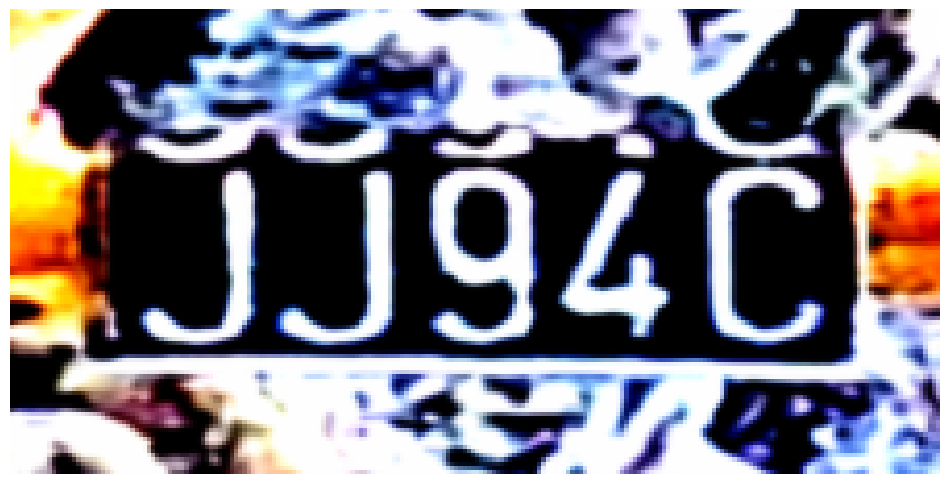

: 

: 

In [ ]:
img, bb, l = exp_dataset[1]
print(bb)

draw_image_with_bb(img, bb)


: 

: 

In [ ]:
def draw_image(img):
    img_uint8 = (img * 255).to(dtype=torch.uint8)
    img_uint8 = img_uint8.permute(1, 2, 0)
    plt.figure(figsize=(12,12))
    plt.imshow(img_uint8)
    plt.axis("off")
    plt.show()

: 

: 

In [ ]:

def crop_image_with_bb(image, bb):
    x = int(bb[0])
    y = int(bb[1])
    width = int(bb[2]) - int(bb[0])
    height = int(bb[3]) - int(bb[1])

    img_crop = F.crop(image, top=y, left=x, height=height, width=width)
    return img_crop


: 

: 

In [ ]:

exp_loader = DataLoader(dataset=exp_dataset, batch_size=64, shuffle=True)


: 

: 

: 

: 

In [ ]:
def prediction(dataloader):
    preds = []
    targets = []
    for images, bb, labels in dataloader:
        images = BWDatasets.tensor_to_numpy(images)
        labels = labels[0]
        for i, image in enumerate(images):

            result = ocr.predict(image)

            pred = result[0]["rec_texts"]

            if not pred:
                pred = ['Not Found']

            preds.append(pred[0])

            label = labels[i]
            
            targets.append(label)

            # print("-------------------")
            # print(f'Prediction: {pred}')
            # print(f'Actual: {label}')

            # plt.figure(figsize=(4,2))
            # plt.imshow(image, cmap="gray")
            # plt.axis("off")
            # plt.show()
    return preds, targets


: 

: 

In [ ]:
def evaluate_model(preds, labels):
    print(f'preds: {preds}')
    print(f'labesl: {labels}')
    # Boolean mask for the predictions and the labels
    # Prediction = 1 if it is correct, 0 otherwise
    # Labels are always = to 1
    bin_preds = [int(pred == label) for pred, label in zip(preds, labels)]
    bin_labels = [1]*len(labels)

    preds_tensor, labels_tensor = torch.tensor(bin_preds), torch.tensor(bin_labels)
    fbeta = FBetaScore(task='binary', beta=0.5)
    acc = Accuracy(task='binary')

    print(f'Model F1 Score: {fbeta(preds_tensor, labels_tensor)}')
    print(f'Model Accuracy: {acc(preds_tensor, labels_tensor)}')
    # print(f'preds: {preds_tensor}')
    # print(f'labesl: {labels_tensor}')

: 

: 

In [ ]:
preds, labels = prediction(exp_loader)


: 

: 

In [ ]:
evaluate_model(preds=preds, labels=labels)


preds: ['Not Found', 'JC791', '376P', 'JJ94C', 'J69i', 'Not Found', 'J701T', 'JCL4', '15', 'JJ94C', '', 'Not Found', 'J223V', 'Not Found', 'JEUOP', 'DL05D', 'Not Found', 'Not Found', 'JE25X', 'JC491', 'Not Found', '16737', 'JE49C', 'Not Found', 'JC49T', 'J2TM', 'J808V', 'Not Found', 'JJ94C', 'Sつ', 'L', 'JUIIT', 'A8U81', 'Not Found', '78077', 'Not Found', 'IC0IM', 'JJ94C', 'J9447', 'JC41J', 'J725V', 'JC491', 'K808T', 'J494H', 'Dco', 'Not Found', '78010', '7801', 'JEOOP', 'J808V', 'E49C', 'J808V', '7', 'JE25X', 'JC791', 'JE23X', 'JE25X', 'Not Found', '份', 'Not Found', 'JN869', 'Not Found', '正2', 'JJ94C', 'ICLJT', 'Not Found', 'JEUUt', '艺', 'Not Found', 'JE25X', 'JL084', 'Not Found', 'Not Found', 'Not Found', 'JJ94C', 'Not Found', 'Not Found', 'J808V', 'JJ94C', 'Not Found', 'Not Found', '8', 'J808V', 'JL050', 'JE25X', 'Not Found', 'Not Found', 'Not Found', 'J808V', 'A8081', 'J149V', 'coe', 'A8U81', 'JCOIM', 'JC78I', 'JN869', 'Not Found', '698N', 'Q081', 'Not Found']
labesl: ['JJ94C', 'JC7

: 

: 

: 

: 

: 

: 